# Exploratory Data Analysis and Preprocessing

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from utils import *

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import TargetEncoder


In [24]:
df = pd.read_csv('data/train_data.csv')

## Data Cleaning

### Missing Values

In [25]:
df["Claim Injury Type"].value_counts(dropna=False)
df = df.dropna(subset=["Claim Injury Type"]) # quase tudo nulos


df["IME-4 Count"] = np.where(df["IME-4 Count"].isna(), 0, df["IME-4 Count"])

df["Industry Code Description"] = np.where(df["Industry Code Description"].isna(), "Missing", df["Industry Code Description"])

df["WCIO Cause of Injury Description"] = np.where(df["WCIO Cause of Injury Description"].isna(), "Missing", df["WCIO Cause of Injury Description"])

df["WCIO Nature of Injury Description"] = np.where(df["WCIO Nature of Injury Description"].isna(), "Missing", df["WCIO Nature of Injury Description"])

df["WCIO Part Of Body Description"] = np.where(df["WCIO Part Of Body Description"].isna(), "Missing", df["WCIO Part Of Body Description"])


med_region = {}
for county in df["County of Injury"].unique():
    med_region[county] = df[df["County of Injury"] == county]["Medical Fee Region"].mode()[0]
    
# fill unknwons 
df["Medical Fee Region"] = np.where(df["Medical Fee Region"] == "UK", df["County of Injury"].map(med_region), df["Medical Fee Region"])


df["Zip Code"] = df["Zip Code"].astype(str)
df["Zip Code"] = df["Zip Code"].fillna("missing")

### Redudant features

In [26]:
df.drop(["Industry Code", "WCIO Cause of Injury Code", "WCIO Nature of Injury Code", "WCIO Part Of Body Code"], axis=1, inplace=True)

df.drop(["OIICS Nature of Injury Description"], axis=1, inplace=True)


### Duplicates

In [27]:
df = df.set_index("Claim Identifier")
df[df.index.duplicated(keep=False)]
df = df[~df.index.duplicated(keep='first')]


### Datatypes correction

In [28]:

df["Alternative Dispute Resolution"] = np.where(df["Alternative Dispute Resolution"] == "U", "Y", df["Alternative Dispute Resolution"])
df["Alternative Dispute Resolution"] = df["Alternative Dispute Resolution"].map({"Y": True, "N": False})



df["Attorney/Representative"] = df["Attorney/Representative"].map({"Y": True, "N": False})


df["COVID-19 Indicator"] = df["COVID-19 Indicator"].map({"Y": True, "N": False})



### Incoherencies

In [29]:

df["Zip Code"] = np.where(df["Zip Code"].str.isnumeric() == False, "missing", df["Zip Code"])



## Feature Engineering

### Dates

In [30]:

for feat in df.columns:
    if "Date" in feat:
        df[feat] = pd.to_datetime(df[feat], format="%Y-%m-%d")
date_feats = [feat for feat in df.columns if "Date" in feat]
date_feats.append("Birth Year")


df["Accident Date_year"] = df["Accident Date"].dt.year

df["Accident Date_missing"] = np.where(df["Accident Date"].isna(), True, False)

df["Accident Date_weekday"] = df["Accident Date"].dt.weekday

df["Accident_weekend"] = np.where(df["Accident Date_weekday"].isin([5, 6]), True, False)

df["Accident Date_month"] = df["Accident Date"].dt.month


df["Accident Date_month_cos"] = np.cos(2 * np.pi * df["Accident Date_month"] / 12)
df["Accident Date_month_sin"] = np.sin(2 * np.pi * df["Accident Date_month"] / 12)



df["Accident Date_assembly_gap_days"] = (df["Assembly Date"] - df["Accident Date"]).dt.days

df["C3-C2_gap_days"] = (df["C-3 Date"] - df["C-2 Date"]).dt.days

df["C2_missing"] = np.where(df["C-2 Date"].isna(), True, False)

df["C3_missing"] = np.where(df["C-3 Date"].isna(), True, False)

df["C2_Accident_gap_weeks"] = ((df["C-2 Date"] - df["Accident Date"]).dt.days/7)


df["C3_Accident_gap_weeks"] = ((df["C-3 Date"] - df["Accident Date"]).dt.days/7)

df["Hearing Date_missing"] = np.where(df["First Hearing Date"].isna(), True, False)

df["Hearing_C3 gap_months"] = ((df["First Hearing Date"].dt.year - df["C-3 Date"].dt.year) * 12 + (df["First Hearing Date"].dt.month - df["C-3 Date"].dt.month))


df["Hearing_C2 gap_months"] = ((df["First Hearing Date"].dt.year - df["C-2 Date"].dt.year) * 12 + (df["First Hearing Date"].dt.month - df["C-2 Date"].dt.month))



df["Hearing_assembly_gap_months"] = ((df["First Hearing Date"].dt.year - df["Assembly Date"].dt.year) * 12 + (df["First Hearing Date"].dt.month - df["Assembly Date"].dt.month))

df["Days to Assembly"] = (df["Assembly Date"] - df["Assembly Date"].min()).dt.days

df["Days to First Hearing"] = (df["First Hearing Date"] - df["First Hearing Date"].min()).dt.days


df["Days from COVID"] = (df["Accident Date"] - df[df["COVID-19 Indicator"]]["Accident Date"].min()).dt.days

### Numericals

In [31]:

df["Average Weekly Wage_log"] = df["Average Weekly Wage"].apply(lambda x: np.log1p(x))

### Categoricals / Booleans

In [32]:
geo_df = pd.read_csv("data/geo-data.csv")
geo_df[["zipcode", "county"]]


df = df.merge(geo_df[["zipcode", "county"]], how="left", left_on="Zip Code", right_on="zipcode")
df[["County of Injury", "Zip Code", "zipcode", "county"]].head(10)
df = df.rename(columns={"county": "County of Worker"})
df[["County of Injury", "Zip Code", "County of Worker"]].head(10)

df.drop(columns=["zipcode"], inplace=True)



df["County of Worker"] = df["County of Worker"].str.upper()
df[["County of Injury", "Zip Code", "County of Worker"]].head(10)


df["Work_on_distance"] = np.where(df["County of Injury"] == df["County of Worker"], False, True)

## Manual Outlier handling

### Numericals

In [33]:

df["Birth Year"] = np.where(df["Birth Year"] == 0, df["Accident Date"].dt.year - df["Age at Injury"], df["Birth Year"])
df["Birth Year"] = pd.to_datetime(df["Birth Year"], format="%Y")


df["Accident Date_assembly_gap_days"] = np.where(df["Accident Date_assembly_gap_days"] > 30, 30, df["Accident Date_assembly_gap_days"])


df["C3-C2_gap_days"] = np.where(df["C3-C2_gap_days"] < -60, -60, df["C3-C2_gap_days"])
df["C3-C2_gap_days"] = np.where(df["C3-C2_gap_days"] > 60, 60, df["C3-C2_gap_days"])




df["C2_Accident_gap_weeks"] = np.where(df["C2_Accident_gap_weeks"] < -4, -4, df["C2_Accident_gap_weeks"])
df["C2_Accident_gap_weeks"] = np.where(df["C2_Accident_gap_weeks"] > 24, 24, df["C2_Accident_gap_weeks"])


df["C3_Accident_gap_weeks"] = np.where(df["C3_Accident_gap_weeks"] < -4, -4, df["C3_Accident_gap_weeks"])
df["C3_Accident_gap_weeks"] = np.where(df["C3_Accident_gap_weeks"] > 24, 24, df["C3_Accident_gap_weeks"])


df["Hearing_C3 gap_months"] = np.where(df["Hearing_C3 gap_months"] > 50, 50, df["Hearing_C3 gap_months"])
df["Hearing_C3 gap_months"] = np.where(df["Hearing_C3 gap_months"] < -20, -20, df["Hearing_C3 gap_months"])

df["Hearing_C2 gap_months"] = np.where(df["Hearing_C2 gap_months"] > 50, 50, df["Hearing_C2 gap_months"])
df["Hearing_C2 gap_months"] = np.where(df["Hearing_C2 gap_months"] < -20, -20, df["Hearing_C2 gap_months"])

df["Days from COVID"] = np.where(df["Days from COVID"] < -200, -200, df["Days from COVID"])



df["Age at Injury"] = np.where(df["Age at Injury"] > 90, 90, df["Age at Injury"])

df["Age at Injury"] = np.where(df["Age at Injury"] == 0, df["Accident Date"].dt.year - df["Birth Year"].dt.year, df["Age at Injury"])

df["Birth Year"] = np.where(df["Birth Year"].isna() & ~(df["Accident Date"].isna()), pd.to_datetime(df["Accident Date"].dt.year - df["Age at Injury"], format="%Y"), df["Birth Year"])

df["Age at Injury"] = np.where(df["Age at Injury"] == 0, df["Accident Date"].dt.year - df["Birth Year"].dt.year, df["Age at Injury"])

df["Age at Injury"] = np.where(df["Age at Injury"] < 14, np.nan, df["Age at Injury"])
df["Age_not_correct"] = np.where(df["Age at Injury"].isna(), True, False)

df["IME-4 Count"] = np.where(df["IME-4 Count"] > 12, 12, df["IME-4 Count"])





### Categoricals

In [34]:

underrepresented_carrier = df["Carrier Name"].value_counts()[df["Carrier Name"].value_counts() < 30].index
df["Carrier Name"] = np.where(df["Carrier Name"].isin(underrepresented_carrier), "Other", df["Carrier Name"])


underrepresented_carrier = df["Carrier Type"].value_counts()[df["Carrier Type"].value_counts() < 30].index
df["Carrier Type"] = np.where(df["Carrier Type"].isin(underrepresented_carrier), "Other", df["Carrier Type"])
df["Carrier Type"] = np.where(df["Carrier Type"] == "Other", "5D. SPECIAL FUND - UNKNOWN", df["Carrier Type"])

underrepresented_zips = df["Zip Code"].value_counts()[df["Zip Code"].value_counts() < 30].index
df["Zip Code"] = np.where(df["Zip Code"].isin(underrepresented_zips), "Other", df["Zip Code"])


### Target Encoding

In [35]:
ordinalencoder = OrdinalEncoder(categories=[["1. CANCELLED", "2. NON-COMP", "3. MED ONLY", "4. TEMPORARY", "5. PPD SCH LOSS", "6. PPD NSL", "7. PTD", "8. DEATH"]])

ordinalencoder.fit(df[["Claim Injury Type"]])

df["Claim Injury Type_encoded"] = ordinalencoder.transform(df[["Claim Injury Type"]])


## Cleaned dataset

In [36]:
features = [feat for feat in df.columns if df[feat].dtype != "datetime64[ns]"]

df[features].to_csv("data/train_new_feats.csv", index=False)

## Multivariate analysis

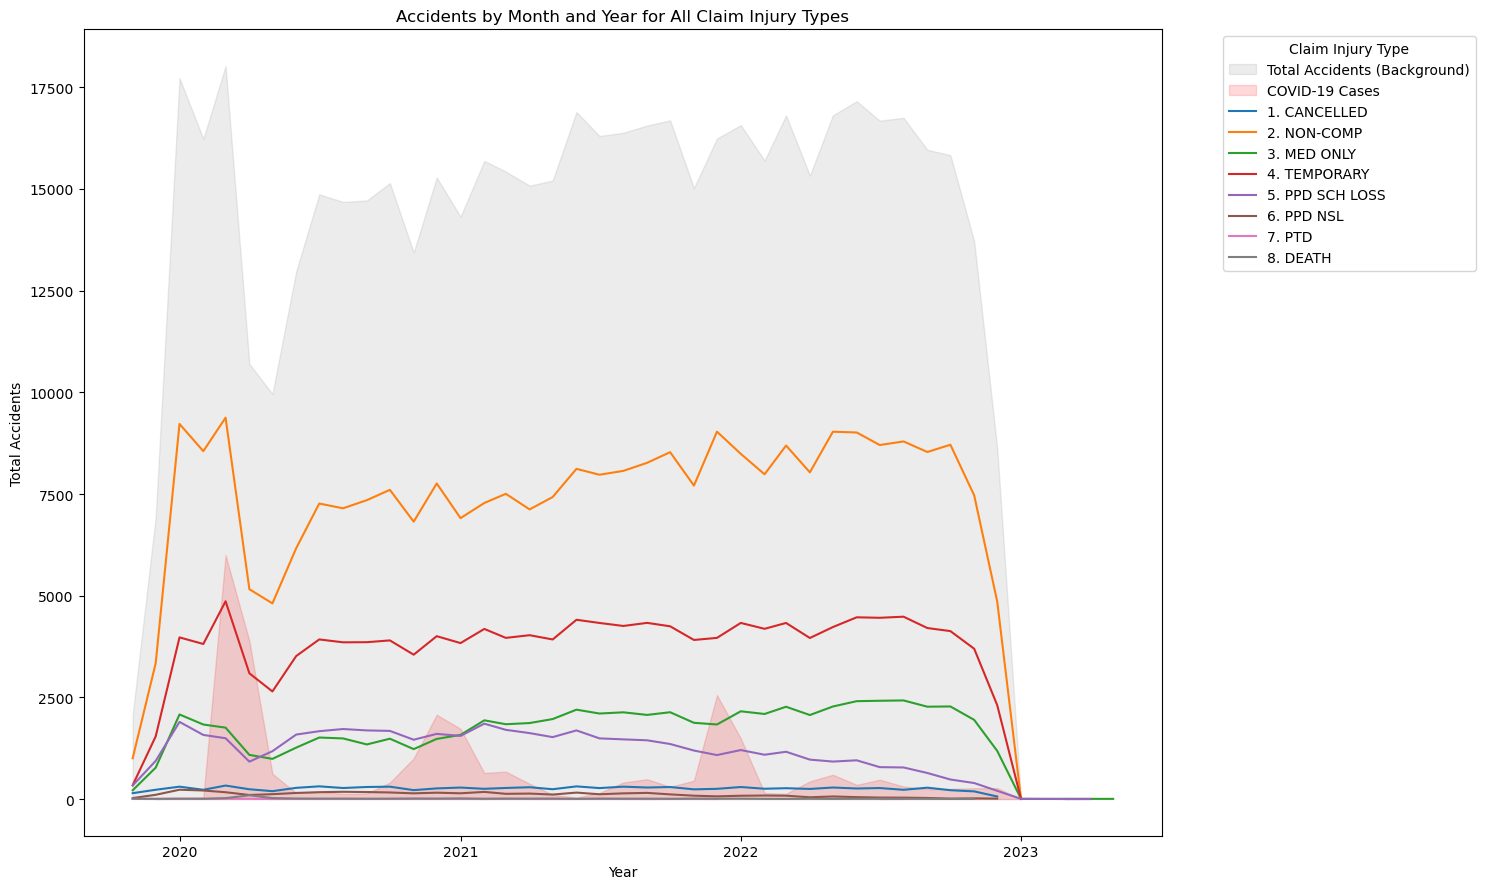

In [37]:
for i, target in enumerate(sorted(df["Claim Injury Type"].unique())):
    df[f"target_{i+1}"] = np.where(df["Claim Injury Type"] == target, 1, 0)

img = df.copy()
img["accident_month_year"] = img["Accident Date"].dt.to_period('M')

combined_data = {}


    
for target in sorted(df["Claim Injury Type"].unique()):
    img_target = img[img["Claim Injury Type"] == target]
    img_target = img_target.groupby("accident_month_year")[["target_1", "target_2", "target_3", "target_4", "target_5", "target_6", "target_7", "target_8"]].sum()
    
    img_target = img_target[img_target.index > '2019-10']
    img_target = img_target[img_target.index < '2023-06']
    
    combined_data[target] = img_target.sum(axis=1)  

combined_df = pd.DataFrame(combined_data)
total_accidents = combined_df.sum(axis=1)

covid_cases = img[img["COVID-19 Indicator"] == 1].groupby("accident_month_year").size()
covid_cases = covid_cases[covid_cases.index > '2019-10'] 
covid_cases = covid_cases[covid_cases.index < '2023-06']

# Convert indexes to datetime
combined_df.index = combined_df.index.to_timestamp()
total_accidents.index = total_accidents.index.to_timestamp()
covid_cases.index = covid_cases.index.to_timestamp()

# Plotting
fig, ax = plt.subplots(figsize=(15, 9))
ax.fill_between(total_accidents.index, 0, total_accidents, color='gray', alpha=0.15, label='Total Accidents (Background)')
ax.fill_between(covid_cases.index, 0, covid_cases, color='red', alpha=0.15, label='COVID-19 Cases')

for column in combined_df.columns:
    ax.plot(combined_df.index, combined_df[column], label=column)

# Set x-ticks to January of each year
year_ticks = combined_df.index[combined_df.index.month == 1].drop_duplicates()
ax.set_xticks(year_ticks)
ax.set_xticklabels([dt.strftime('%Y') for dt in year_ticks])

# Axis labels and title
plt.title("Accidents by Month and Year for All Claim Injury Types")
plt.ylabel("Total Accidents")
plt.xlabel("Year")
plt.legend(title="Claim Injury Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

